# A Simple Optimal Statistic Example

## Read in the residual data, design matrices and sky locations

In [44]:
# get all of the residual and design matrix data
rdata <- Sys.glob('mdc_data/datafiles/*.res')
Mdata <- Sys.glob('mdc_data/datafiles/*.dmat')

sky_loc_table <- read.table('mdc_data/datafiles/sky_locs.txt', header=FALSE, sep="")

In [45]:
# read data into lists, where each element in the list is for a specific pulsar
psrs = list()
ct <- 1
for (xx in mapply(list, rdata, Mdata, SIMPLIFY=F)){
    psr <- list(name=sky_loc_table[ct,1])
    dat <- read.table(xx[[1]], header = FALSE, sep = "")
    psr$Mmat <- as.matrix(read.table(xx[[2]], header = FALSE, sep = ""))
    psr$toas <- dat[,1]
    psr$res <- dat[,2]
    psr$err <- dat[,3]
    psr$theta <- sky_loc_table[ct,2]
    psr$phi <- sky_loc_table[ct,3]
    psrs[[ct]] <- psr
    ct <- ct + 1
}

## Some auxiliary functions to create the needed matrices

In [46]:
# Creates the Fourier design matrix F
create_fourier_designmatrix <- function(time, nmode = 30) {

F.matrix <- matrix(0, nrow = length(time), ncol = 2 * nmode)
    T.total.time.span <- max(time) - min(time)
    f.frequencies <- seq(1 / T.total.time.span, 
                         nmode / T.total.time.span, 
                         length = nmode)

    F.matrix[, seq(1, (2 * nmode), by = 2)] <- sin(2 * pi * (time %*% t(f.frequencies)))
    F.matrix[, seq(2, (2 * nmode), by = 2)] <- cos(2 * pi * (time %*% t(f.frequencies)))

    output <- list(f.freq = f.frequencies, F.mat = F.matrix)
    return(output)
    
}

# get unit vector pointing from earth to pulsar
create_earth_pulsar_uvector <- function(theta, phi){
    px <- sin(theta) * cos(phi)
    py <- sin(theta) * sin(phi)
    pz <- cos(theta)
    return(c(px, py, pz))
}

# creates the red noise \varphi diagonal
create_pl_matrix <- function(A, gamma, freq) {

    # normalization
    f1yr = 1 / 3.16e7

    # T is the total timespan of the data
    Pf = A^2 / 12 / pi^2 * f1yr^(gamma - 3) * freq^(-gamma) * freq[1]

    return(rep(Pf, each = 2))

}


# creates B^{-1} including timing model and red noise
create_B_inv <- function(A, gamma, freq, ntmpars){

    return(c(rep(0, ntmpars), 1 / create_pl_matrix(A, gamma, freq)))

}

# Hellings-Downs overlap reduction function
hd_orf <- function(xi){
    omc2 = (1 - cos(xi)) / 2
    return(1.5 * omc2 * log(omc2) - 0.25 * omc2 + 0.5)
}



## Functions to setup necessary arrays in pulsar list

In [47]:
# there is probably a cleaner way to do this...
init_arrays <- function(psrlist){
    
    for (ii in 1:length(psrlist)){
        
        # get F matrices
        Fout <- create_fourier_designmatrix(psrlist[[ii]]$toas)
        psrlist[[ii]]$Fmat <- Fout$F.mat
        psrlist[[ii]]$freqs <- Fout$f.freq
        
        # get pulsar unit vectors
        psrlist[[ii]]$pos <- create_earth_pulsar_uvector(psrlist[[ii]]$theta, psrlist[[ii]]$phi)
        
        psrlist[[ii]]$Tmat <- cbind(psrlist[[ii]]$Mmat, Fout$F.mat)
        
    }
    psrlist
}

## Function to compute Optimal Statistic

In [48]:
compute_os <- function(params, psrlist){
    
    # initialize lists of matrix products to use later
    X <- list()
    Z <- list()
    
    npsr <- length(psrlist)
    for (ii in 1:npsr){
        
        # get white noise and B covariances
        Nvec <- psrlist[[ii]]$err^2
        ntmpars <- dim(psrlist[[ii]]$Mmat)[2]
        freq <- psrlist[[ii]]$freq
        A <- 10^params[2*ii-1]
        gamma <- params[2*ii]
        Binv <- create_B_inv(A, gamma, freq, ntmpars)
        
        # compute T^T N^{-1} \delta t
        TNr <- t(psrlist[[ii]]$Tmat) %*% (psrlist[[ii]]$res / Nvec)
        
        # compute F^T N^{-1} \delta t
        FNr <- t(psrlist[[ii]]$Fmat) %*% (psrlist[[ii]]$res / Nvec)
        
        # compute T^TN^{-1}T
        TNT <- t(psrlist[[ii]]$Tmat) %*% (psrlist[[ii]]$Tmat / Nvec)
        
        # compute F^TN^{-1}F
        FNF <- t(psrlist[[ii]]$Fmat) %*% (psrlist[[ii]]$Fmat / Nvec)
        
        # compute F^TN^{-1}T
        FNT <- t(psrlist[[ii]]$Fmat) %*% (psrlist[[ii]]$Tmat / Nvec)
        
        # compute \Sigma = T^TN^{-1}T + B^{-1}
        Sigma <- TNT + diag(Binv)
        
        # compute F^T N^{-1} T \Sigma^{-1} d
        cf = chol(Sigma)
        Sigma.inv = chol2inv(cf)
        SigmaInvd <- Sigma.inv %*% TNr
        SigmaInvTNF <- Sigma.inv %*% t(FNT)
        FNTSigmad <- FNT %*% SigmaInvd
        
        # X = F^T[N^{-1} - N^{-1} T \Sigma^{-1} T^T N^{-1}]\delta t
        X[[ii]] <- as.numeric(FNr - FNTSigmad)
        
        # Z = F^T [N^{-1} - N^{-1} T \Sigma^{-1} T^T N^{-1}] F
        Z[[ii]] <- FNF - FNT %*% SigmaInvTNF
        
    }
    
    # cross terms
    rho <- list()
    sig <- list()
    xi <- list()
    ct <- 1
    for (ii in 1:(npsr-1)){
        fgw <- psrlist[[ii]]$freq
        for (jj in (ii+1):npsr){
            
            # constructing \tilde{S}_{ab} = F_a \varphi_{gw} F_b^T
            Amp <- 1
            gamma <- 13/3
            f1yr <- 1 / 3.16e7
            phiab <- create_pl_matrix(Amp, gamma, fgw)

            # construct the cross correlation coefficients and uncertainties
            top <- X[[ii]] %*% (phiab * X[[jj]])
            bot <- sum(diag((Z[[ii]]*phiab) %*% (Z[[jj]] * phiab)))
            rho[[ct]] <- top / bot
            sig[[ct]] <- 1 / sqrt(bot)
            xi[[ct]] <- acos(psrlist[[ii]]$pos %*% psrlist[[jj]]$pos)
            ct <- ct + 1
        
        }
    }
    return(list(xi=as.numeric(xi), rho=as.numeric(rho), sig=as.numeric(sig)))
}

In [49]:
psrlist <- init_arrays(psrs)
npsr <- length(psrlist)
npar <- 2 * npsr
params <- c(rep(0, npar))

# set to true values
params[seq(1, npar, by = 2)] <- log10(1e-14)
params[seq(2, npar, by = 2)] <- 13/3

In [50]:
os <- compute_os(params, psrlist)

In [51]:
orf <- hd_orf(os$xi)
Opt <- sum(os$rho * orf / os$sig^2) / sum(orf^2/os$sig^2)
Sig <- 1 / sqrt(sum(orf^2 / os$sig^2))


In [52]:
Opt/Sig

[1] 9.111961

In [57]:
sqrt(Opt)

[1] 1.193195e-14

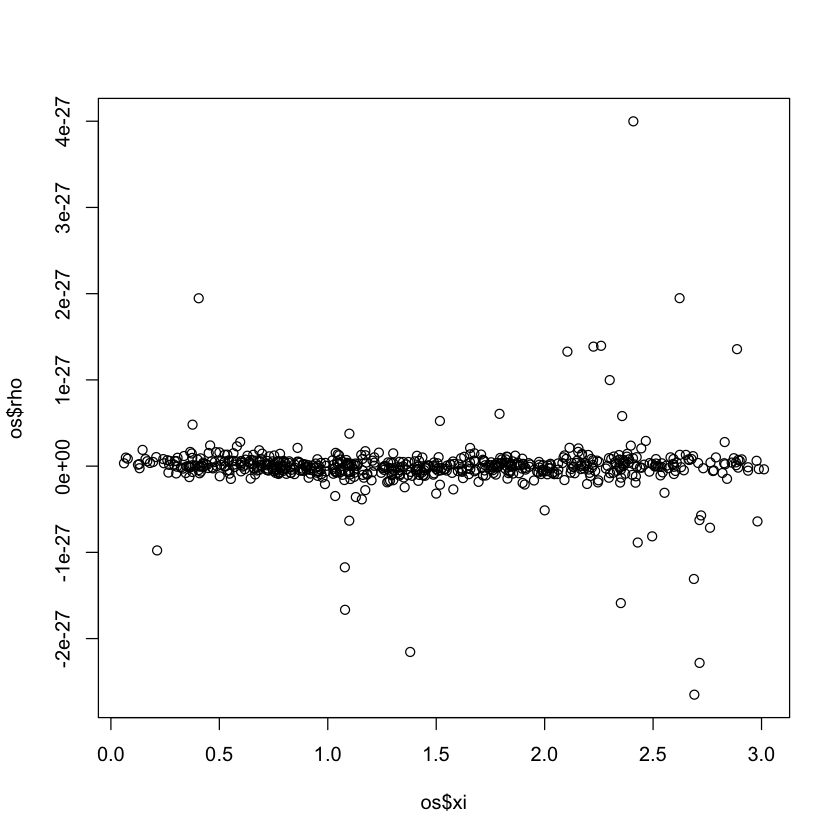

In [53]:
plot(os$xi, os$rho)